# GLM Project



The goal of this project is to create a generalized linear model for prediction of *the number of rooms*.

In [1]:
rm(list = ls())

In [2]:
library(dplyr) |> suppressPackageStartupMessages() 
library(ggplot2) |> suppressPackageStartupMessages() 
library(corrplot) |> suppressPackageStartupMessages() 
library(Metrics) |> suppressPackageStartupMessages() 
library(caret) |> suppressPackageStartupMessages() 

Warning message:
"package 'dplyr' was built under R version 4.1.3"
Warning message:
"package 'ggplot2' was built under R version 4.1.2"
Warning message:
"package 'corrplot' was built under R version 4.1.3"
Warning message:
"package 'Metrics' was built under R version 4.1.3"
Warning message:
"package 'caret' was built under R version 4.1.3"


## Data preparation

In [3]:
# the file fulldata.csv was obtained by merging together all the datasets for individual city parts
#  and adding a new cathegorical variable CityPart
data <- read.csv("fulldata.csv")
data <- data[, -which( names(data) %in% c("X", "Location") )] # we don't need index and location
to_factorise <- names(data)
to_factorise <- to_factorise[!to_factorise %in% c("Price", "Area", "No..of.Bedrooms", "Resale", "CityPart")]

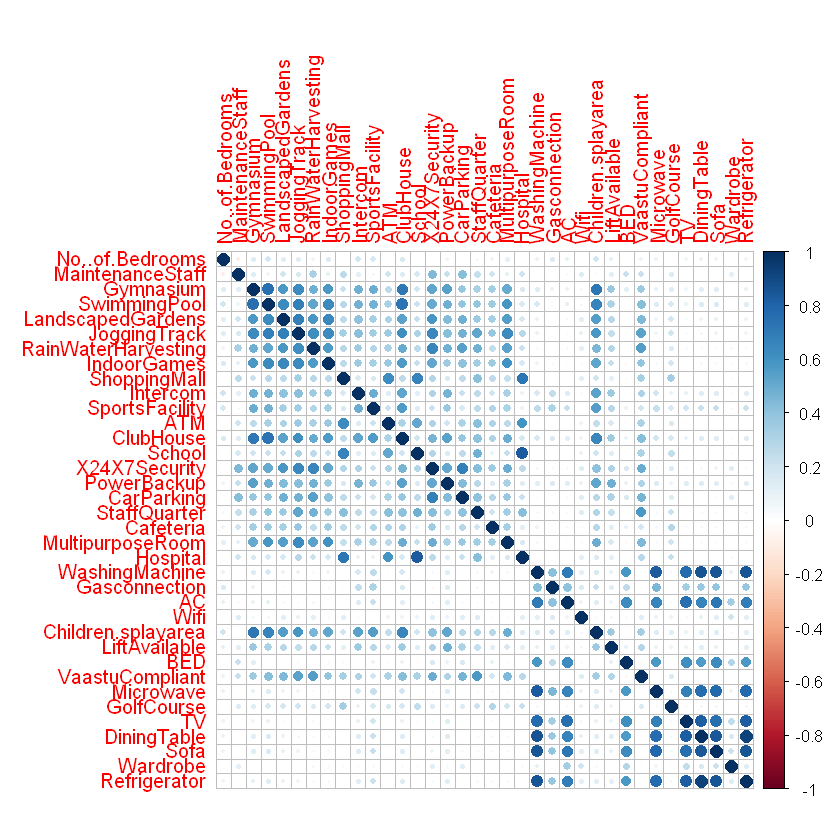

In [4]:
# correlation matrix for the binary "yes/no" variables
corrplot( cor( data[ data$School != 9, c( "No..of.Bedrooms", to_factorise ) ] ) )

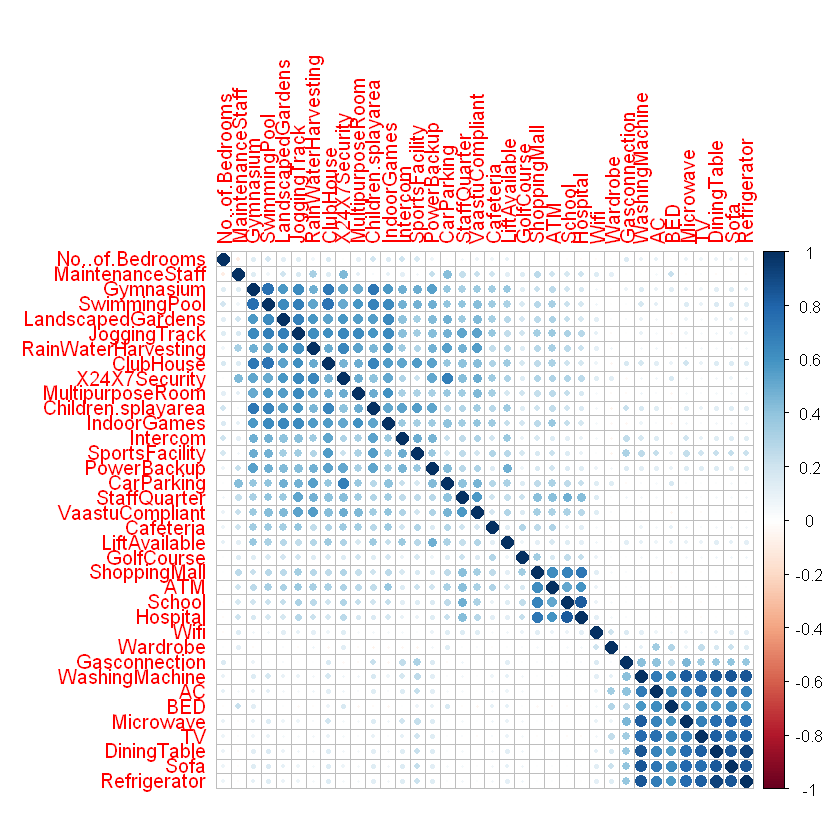

In [5]:
# rearranging variables for better visualisation of correlated clusters
group1 <- c( "MaintenanceStaff", "Gymnasium", "SwimmingPool", "LandscapedGardens", 
             "JoggingTrack", "RainWaterHarvesting", "ClubHouse", "X24X7Security", "MultipurposeRoom", "Children.splayarea",
             "IndoorGames", "Intercom", 
             "SportsFacility", "PowerBackup", 
             "CarParking", "StaffQuarter",  
             "VaastuCompliant", "Cafeteria", 
             "LiftAvailable", "GolfCourse" )
group2 <- c( "ShoppingMall", "ATM", "School", "Hospital" )
group3 <- c( "Wifi", "Wardrobe", "Gasconnection", "WashingMachine", "AC", "BED", "Microwave", "TV", "DiningTable",
             "Sofa", "Refrigerator" )
corrplot( cor( data[ data$School != 9, c( "No..of.Bedrooms", group1, group2, group3 )] ) )

We can see 3 correlated clusters: the first one consists of the "luxury" house infrastructure, the second one are the services nearby and the third one is furniture, appliances etc. 

In [6]:
# factorise the categorical variables
data[,to_factorise] <- lapply(data[,to_factorise], factor)
data$Resale <- data$Resale |> factor()
data$CityPart <- data$CityPart |> factor()

In [7]:
summary(data)

     Price                Area       No..of.Bedrooms Resale    MaintenanceStaff
 Min.   :  2000000   Min.   :  200   Min.   :1.000   0:20391   0: 8373         
 1st Qu.:  4071500   1st Qu.:  853   1st Qu.:2.000   1:12572   1: 1720         
 Median :  6711000   Median : 1125   Median :2.000             9:22870         
 Mean   : 11686718   Mean   : 1293   Mean   :2.412                             
 3rd Qu.: 12000000   3rd Qu.: 1500   3rd Qu.:3.000                             
 Max.   :854599999   Max.   :16000   Max.   :9.000                             
 Gymnasium SwimmingPool LandscapedGardens JoggingTrack RainWaterHarvesting
 0: 4837   0: 5905      0: 6570           0: 6729      0: 6382            
 1: 5256   1: 4188      1: 3523           1: 3364      1: 3711            
 9:22870   9:22870      9:22870           9:22870      9:22870            
                                                                          
                                                                 

#### Exploring the missing values

In [8]:
NAcount <- rowSums( data[,to_factorise] == 9 )
sum( NAcount != 0 )
sum( NAcount[ NAcount != 0 ] == length(to_factorise) )
data$had_NA <- (NAcount != 0)

[1] 22870

[1] 22870

so, every datapoint either has '9' (= missing value) in all "yes/no" categories, or in none of them

=> looks like for 2/3 of the data (22870 rows), these values were not being recorded.

1     2     3     4     5     6     7     8     9 
 3857 14263 12596  1983   214    33     9     7     1

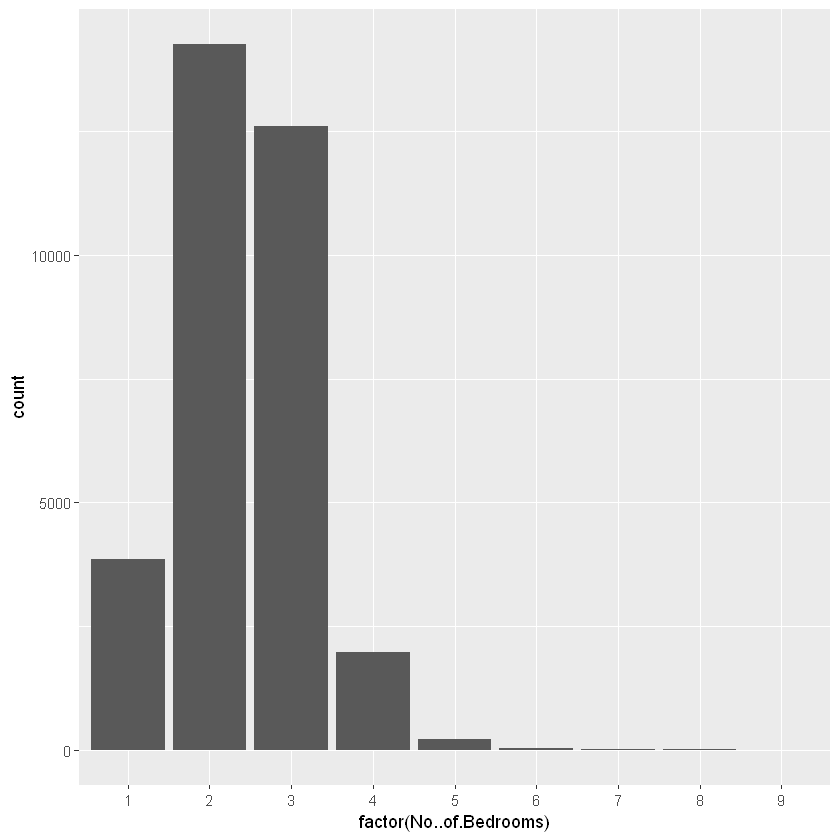

In [9]:
summary(factor(data$No..of.Bedrooms))
ggplot(data, aes(x = factor(No..of.Bedrooms) ) ) + geom_bar()

Already the target variable looks like using poisson glm is a good choice for the model.

We will see :)

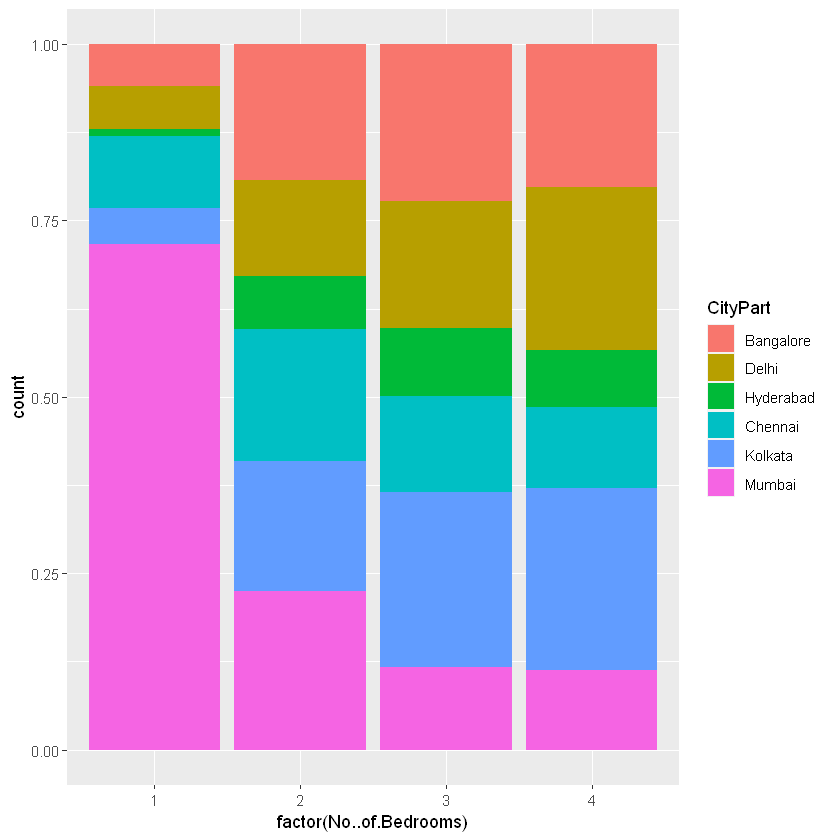

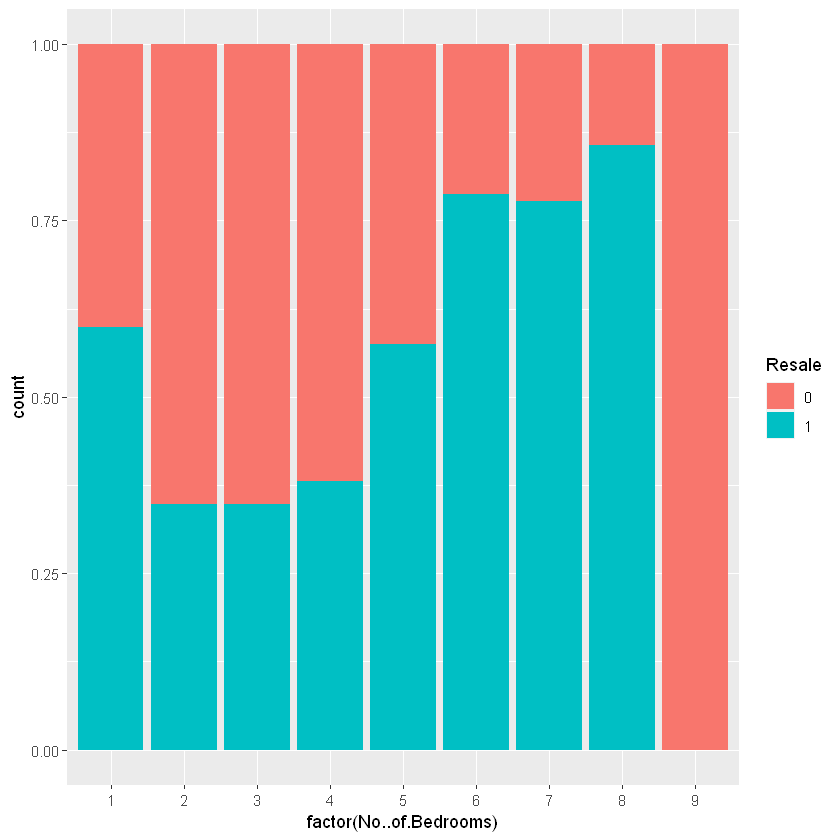

In [10]:
ggplot(data %>% filter( No..of.Bedrooms < 5 ), aes(x = factor(No..of.Bedrooms), fill = CityPart ) ) + 
  geom_bar(position = "fill")
ggplot(data, aes(x = factor(No..of.Bedrooms), fill = Resale)) +
  geom_bar(position = "fill")

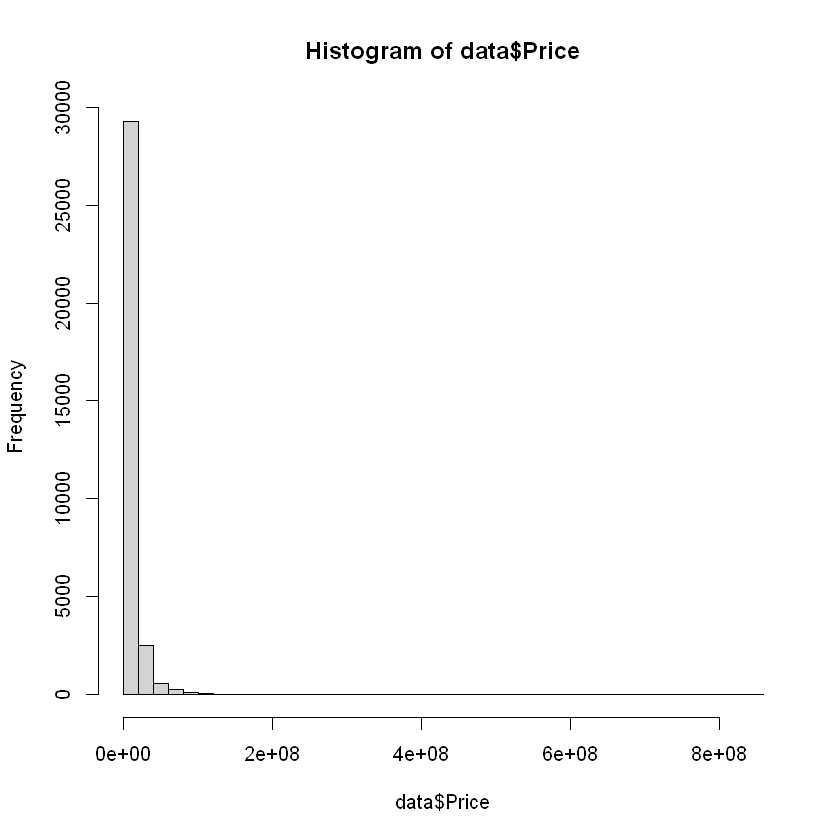

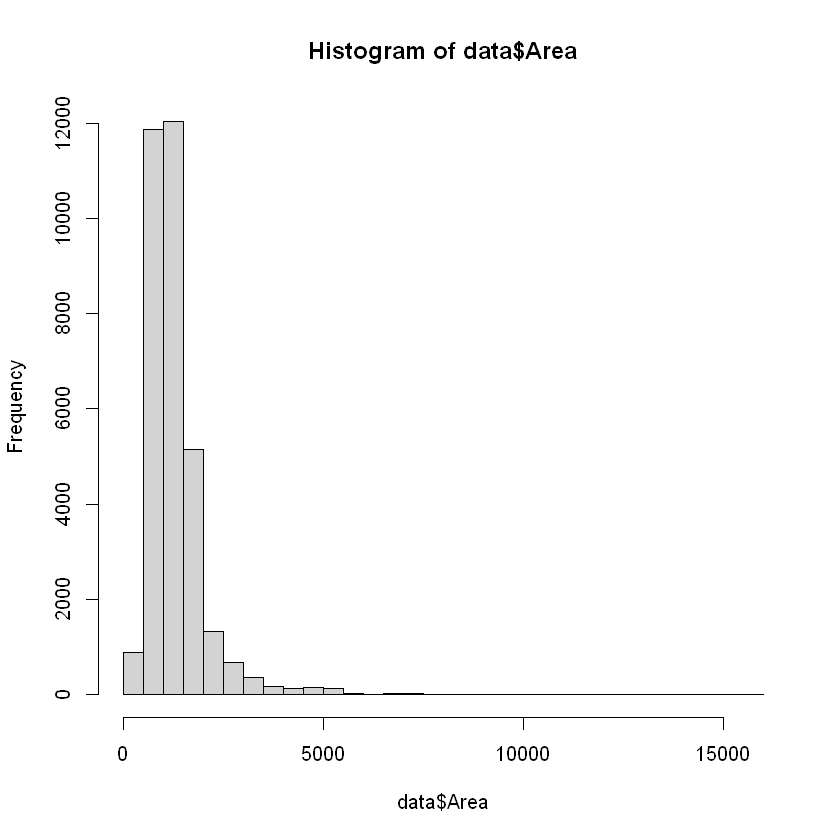

In [11]:
hist(data$Price, breaks = 50)
hist(data$Area, breaks = 50)

These distributions look awful. Let's try to logarithmize them:

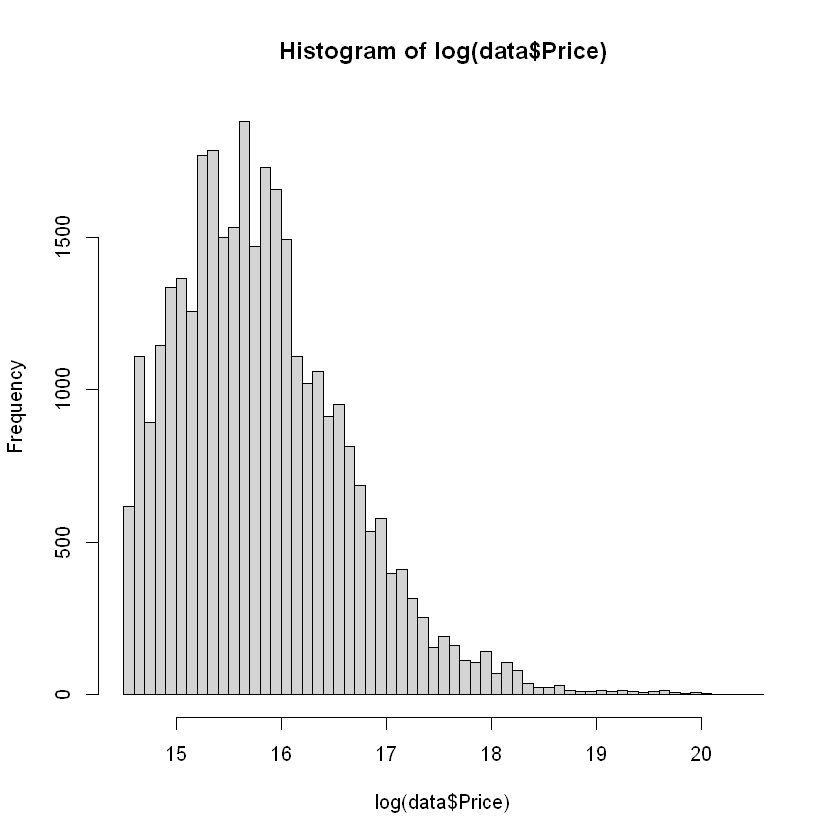

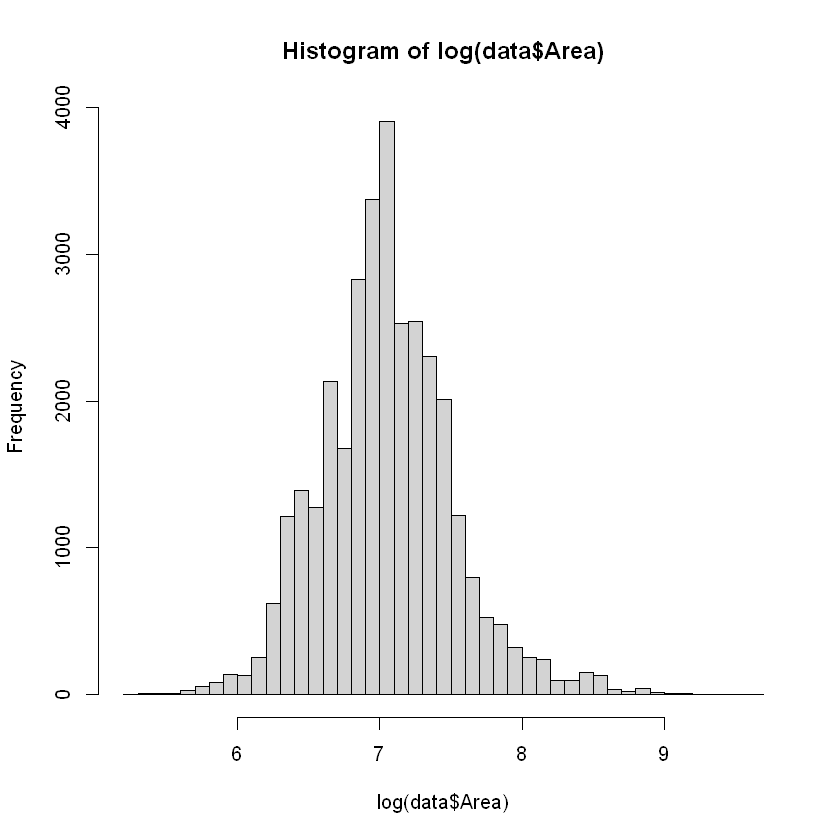

In [12]:
hist(log(data$Price), breaks = 50)
hist(log(data$Area), breaks = 50)

Now this looks much better! This data now looks almost *normal* (also meaning we could use a linear model)

From now on, we will be working with log(Price) and log(Area)

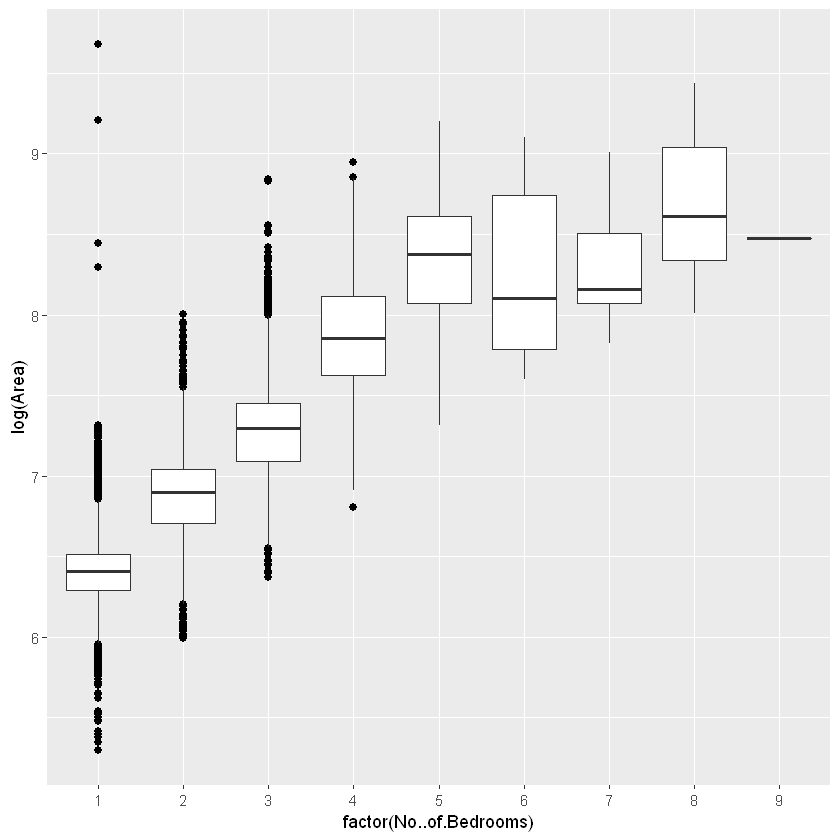

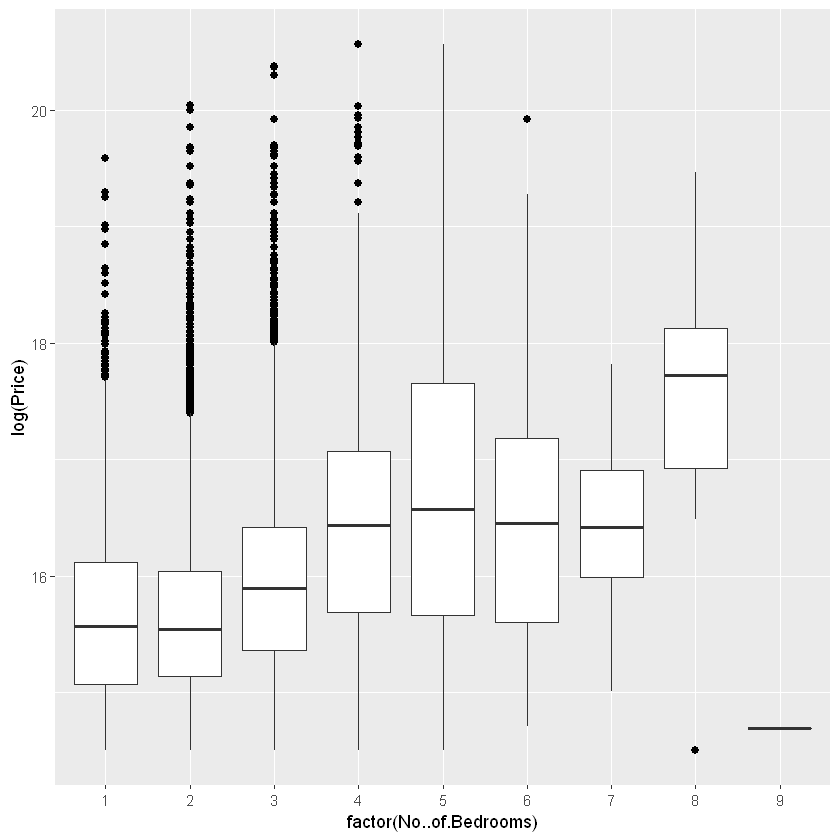

In [13]:
ggplot(data, aes(x=factor(No..of.Bedrooms), y=log(Area) ) ) + 
  geom_boxplot( aes( group = No..of.Bedrooms ), outlier.colour="black", outlier.shape=16,
                outlier.size=2, notch=FALSE)

ggplot(data, aes(x=factor(No..of.Bedrooms), y=log(Price) ) ) + 
  geom_boxplot( aes( group = No..of.Bedrooms ), outlier.colour="black", outlier.shape=16,
                outlier.size=2, notch=FALSE)

We can see a strong relationship between number of rooms and *area*, maybe a weaker one with *price*

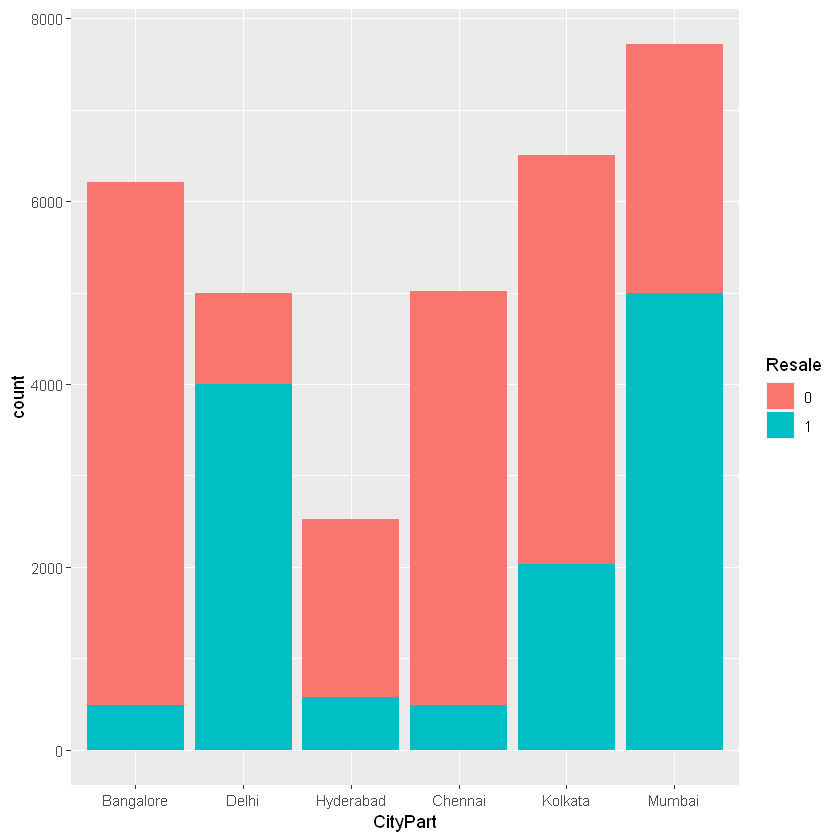

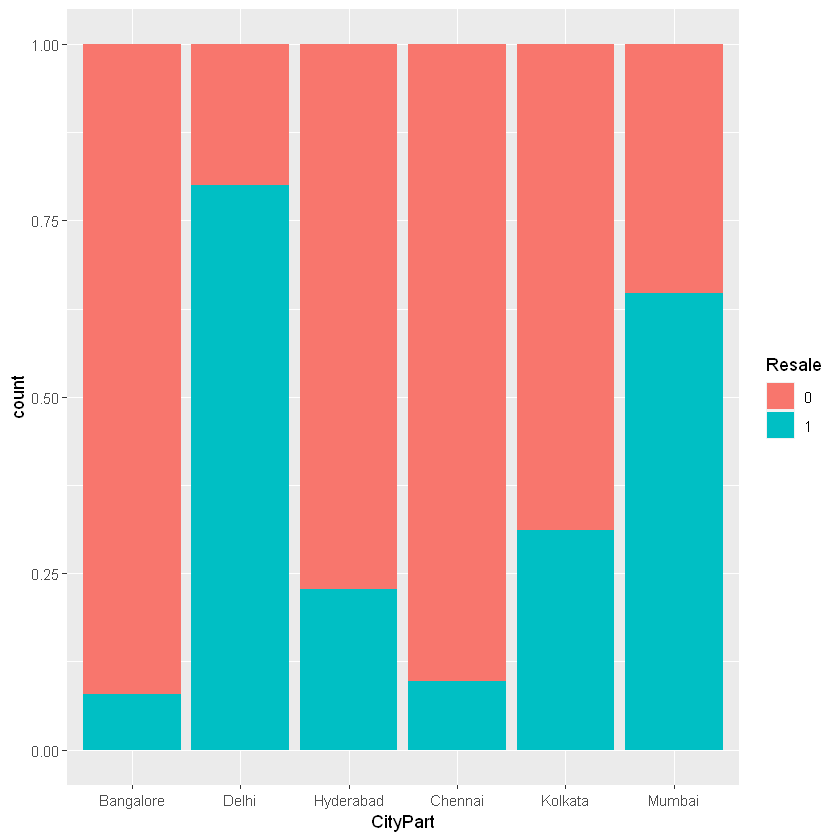

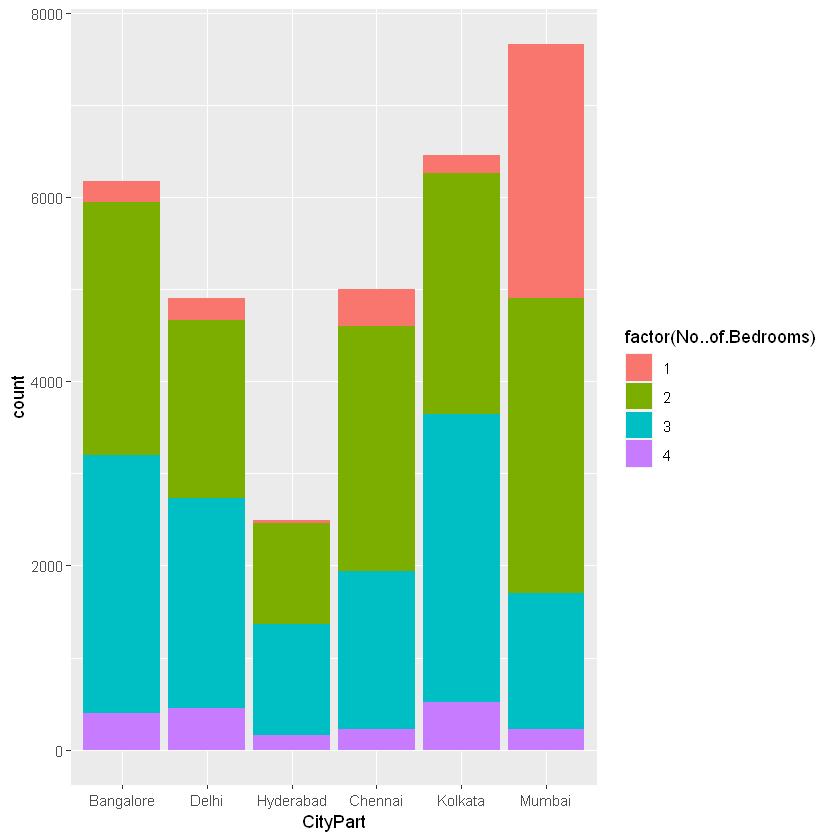

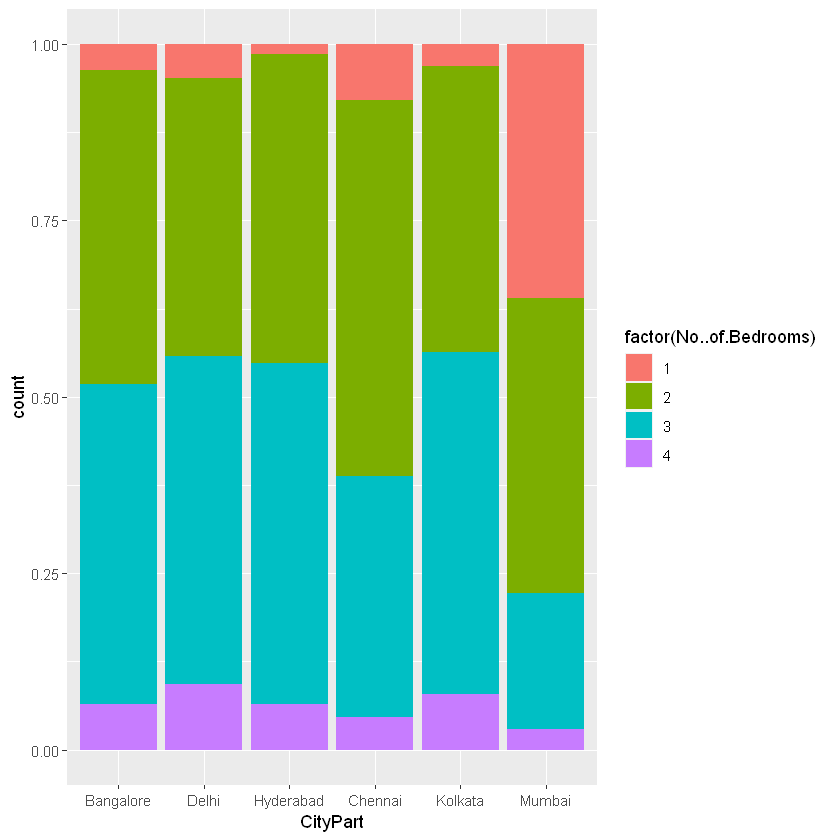

In [14]:
ggplot(data, aes(x = CityPart, fill = Resale)) + geom_bar()
ggplot(data, aes(x = CityPart, fill = Resale)) + geom_bar(position = "fill")
ggplot(data %>% filter( No..of.Bedrooms < 5 ), aes(x = CityPart, fill = factor(No..of.Bedrooms))) +
  geom_bar()
ggplot(data %>% filter( No..of.Bedrooms < 5 ), aes(x = CityPart, fill = factor(No..of.Bedrooms))) +
  geom_bar(position = "fill")

Now let's look at some Price-Area scatterplots.

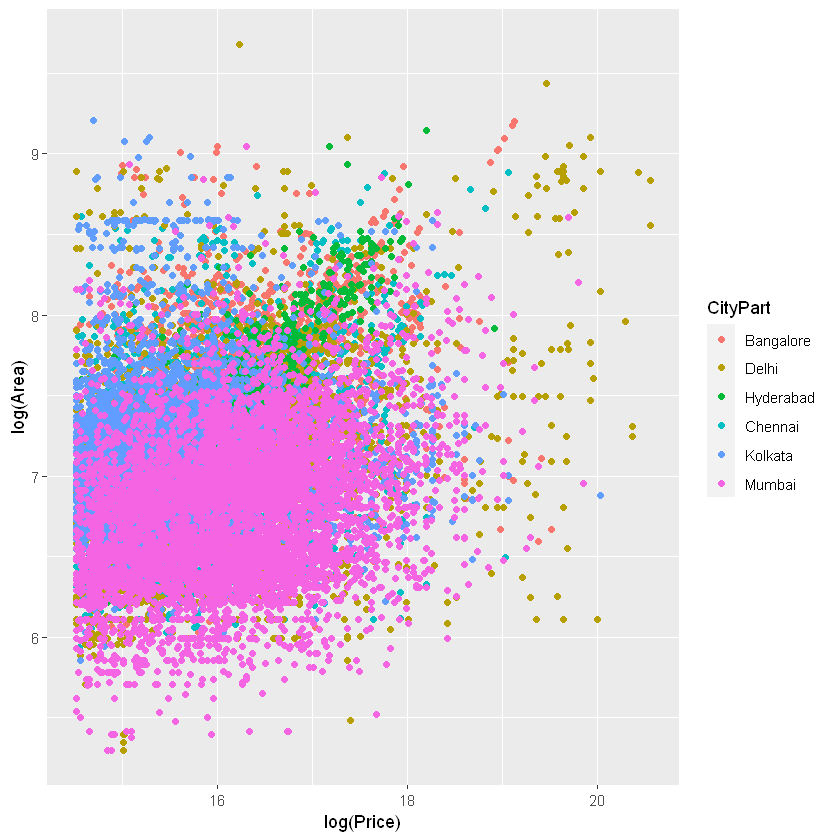

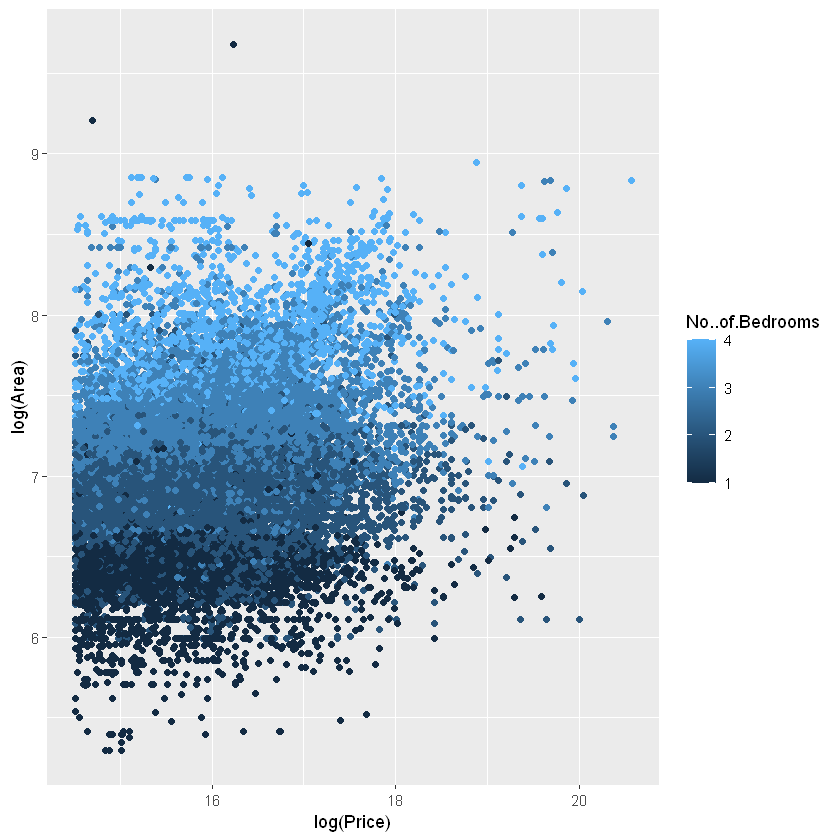

In [15]:
ggplot(data, aes(x=log(Price), y=log(Area) ) ) + 
  geom_point( aes(color = CityPart) )

ggplot(data %>% filter(No..of.Bedrooms < 5), aes(x=log(Price), y=log(Area) ) ) + 
  geom_point( aes(color = No..of.Bedrooms) )

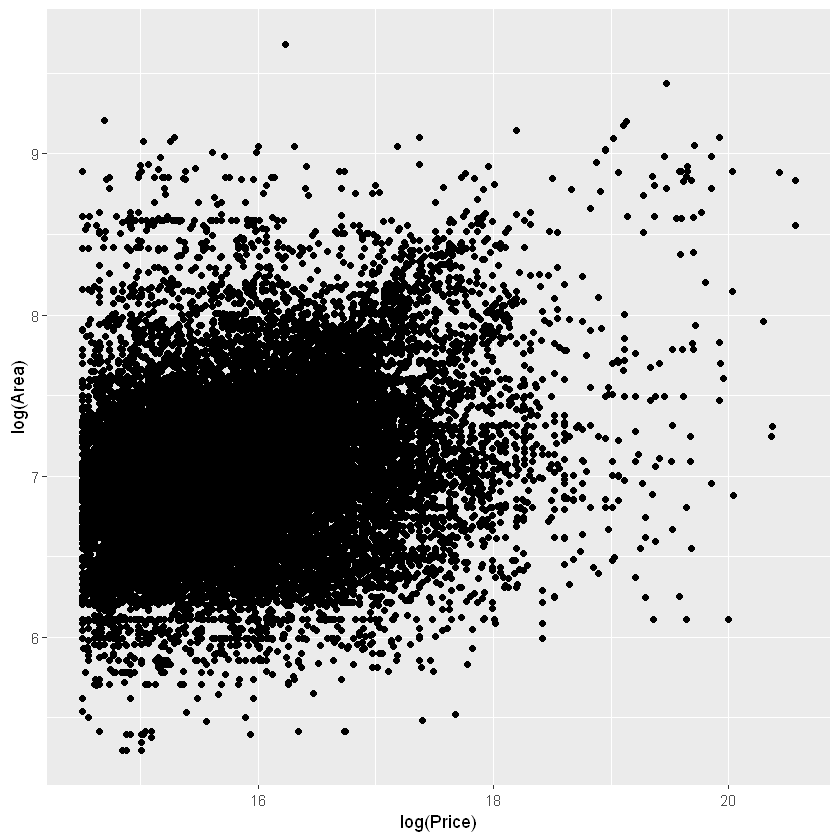

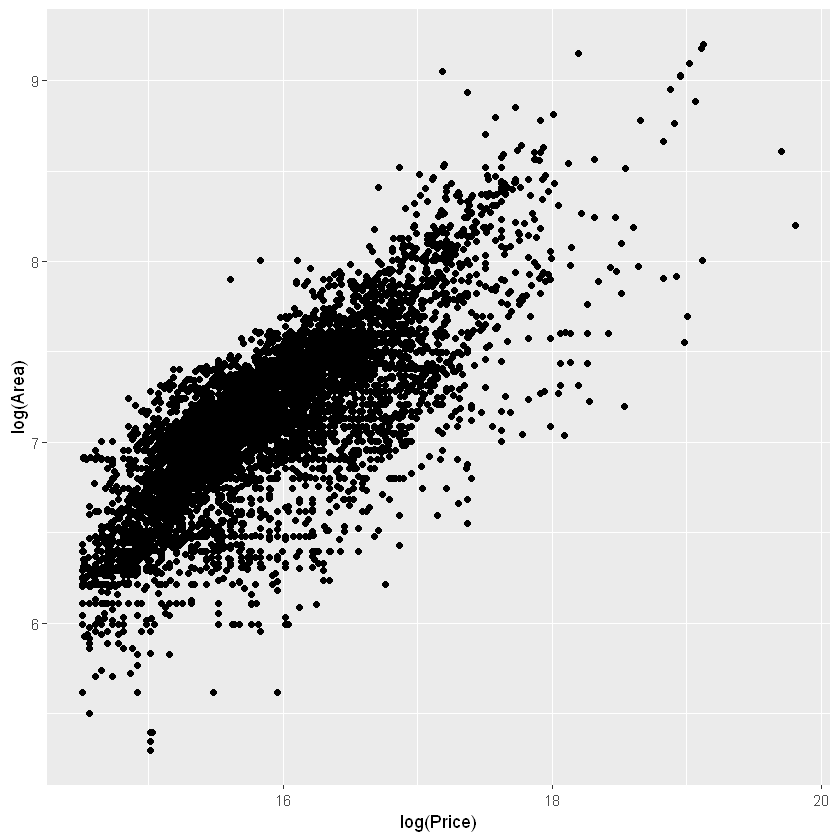

In [16]:
ggplot(data, aes(x=log(Price), y=log(Area) ) ) + geom_point()

ggplot(data %>% filter(MaintenanceStaff != 9), aes(x=log(Price), y=log(Area) ) ) + 
  geom_point()   # removing 9s increases price/area correlation

Now this is a problem. If we remove all the data with missing values in binary categories, the remaining data shows a new pattern 

(namely, Price and Area now have a visible linear relationship).

This is highly problematic! It means that the method of measuring itself would have a significant impact on the model - as we can see in the models below, where the level '9' is statistically significant. We don't want that - we only want the actual data to be influencing the model, not the fact that it is missing. So, removing the missing values is a bad idea (also for the reason that it is the majority), and it's better not to use these binary categories in the model - then it will probably be more robust. We can try, though :-)

## The Model

In [17]:
# splitting data to train and test set, train set is 70%
set.seed(101) # for replicability
n = nrow(data)
trainIndex = sample(1:n, size = round(0.7*n), replace=FALSE)
train = data[trainIndex ,]
test = data[-trainIndex ,]

Let's first try the Poisson model, since that was the first idea

### Poisson glm

In [18]:
data2 <- train
data2$Area <- log(train$Area)
data2$Price <- log(train$Price)
model.poisson_all <- glm(No..of.Bedrooms ~ ., data = data2, family = "poisson" )
summary(model.poisson_all)


Call:
glm(formula = No..of.Bedrooms ~ ., family = "poisson", data = data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9893  -0.1922  -0.0132   0.2088   1.6129  

Coefficients: (35 not defined because of singularities)
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -2.824939   0.089666 -31.505  < 2e-16 ***
Price                -0.011944   0.005887  -2.029  0.04248 *  
Area                  0.547392   0.010243  53.441  < 2e-16 ***
Resale1              -0.047831   0.010900  -4.388 1.14e-05 ***
MaintenanceStaff1     0.005234   0.025712   0.204  0.83868    
MaintenanceStaff9    -0.032771   0.018944  -1.730  0.08365 .  
Gymnasium1           -0.014016   0.029357  -0.477  0.63306    
Gymnasium9                  NA         NA      NA       NA    
SwimmingPool1         0.032019   0.030270   1.058  0.29016    
SwimmingPool9               NA         NA      NA       NA    
LandscapedGardens1   -0.008455   0.024815  -0.341  0.73330  

In [19]:
#===POISSON
model.poisson <- glm(No..of.Bedrooms ~ log(Price) + log(Area) + Resale, 
                     data = train, family = "poisson")
summary(model.poisson)
model.poisson2 <- glm(No..of.Bedrooms ~ log(Price) + log(Area) + Resale + CityPart, 
                      data = train, family = "poisson")
summary(model.poisson2)

anova(model.poisson, model.poisson2, test = "Chisq")
# adding CityPart significantly improves fit

model.poisson3 <- glm(No..of.Bedrooms ~ log(Price) + log(Area) + Resale + CityPart + Children.splayarea, 
                      data = train, family = "poisson")
summary(model.poisson3)

anova(model.poisson2, model.poisson3, test = "Chisq")
# adding Children.splayarea once more significantly improves fit


model.poisson4 <- glm(No..of.Bedrooms ~ log(Price) + log(Area) + Resale + 
                      CityPart + Intercom + PowerBackup + Children.splayarea + LiftAvailable,
                    data = train, family = "poisson" )
summary(model.poisson4)
anova(model.poisson3, model.poisson4, test = "Chisq")
# also improve fit
# so the best poisson model is probably the last one 

exp(model.poisson4$coefficients)


Call:
glm(formula = No..of.Bedrooms ~ log(Price) + log(Area) + Resale, 
    family = "poisson", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.6813  -0.2216  -0.0045   0.2036   1.9183  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.610769   0.085873 -30.403  < 2e-16 ***
log(Price)  -0.030618   0.005534  -5.533 3.15e-08 ***
log(Area)    0.559795   0.009345  59.902  < 2e-16 ***
Resale1     -0.005766   0.008860  -0.651    0.515    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 6531.3  on 23073  degrees of freedom
Residual deviance: 2656.8  on 23070  degrees of freedom
AIC: 65705

Number of Fisher Scoring iterations: 4



Call:
glm(formula = No..of.Bedrooms ~ log(Price) + log(Area) + Resale + 
    CityPart, family = "poisson", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9790  -0.1949  -0.0136   0.2114   1.6208  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -2.778592   0.087359 -31.807  < 2e-16 ***
log(Price)        -0.014608   0.005809  -2.515   0.0119 *  
log(Area)          0.542539   0.010103  53.702  < 2e-16 ***
Resale1           -0.050468   0.010712  -4.711 2.46e-06 ***
CityPartDelhi      0.192511   0.016265  11.836  < 2e-16 ***
CityPartHyderabad -0.009871   0.017573  -0.562   0.5743    
CityPartChennai    0.036568   0.014707   2.487   0.0129 *  
CityPartKolkata    0.108453   0.013575   7.989 1.36e-15 ***
CityPartMumbai    -0.020813   0.015813  -1.316   0.1881    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 6531.

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23070,2656.831,NA,NA,NA
2,23065,2366.844,5,289.9875,1.421964e-60



Call:
glm(formula = No..of.Bedrooms ~ log(Price) + log(Area) + Resale + 
    CityPart + Children.splayarea, family = "poisson", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9862  -0.1960  -0.0143   0.2117   1.6246  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.787980   0.087958 -31.697  < 2e-16 ***
log(Price)          -0.013300   0.005843  -2.276  0.02283 *  
log(Area)            0.546632   0.010180  53.699  < 2e-16 ***
Resale1             -0.050464   0.010705  -4.714 2.43e-06 ***
CityPartDelhi        0.183982   0.016463  11.175  < 2e-16 ***
CityPartHyderabad   -0.027054   0.019182  -1.410  0.15844    
CityPartChennai      0.029621   0.014879   1.991  0.04651 *  
CityPartKolkata      0.108004   0.014019   7.704 1.32e-14 ***
CityPartMumbai      -0.024718   0.016011  -1.544  0.12263    
Children.splayarea1 -0.049079   0.015853  -3.096  0.00196 ** 
Children.splayarea9 -0.040166   0.014074  -2.8

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23065,2366.844,NA,NA,NA
2,23063,2356.024,2,10.81953,0.004472693



Call:
glm(formula = No..of.Bedrooms ~ log(Price) + log(Area) + Resale + 
    CityPart + Intercom + PowerBackup + Children.splayarea + 
    LiftAvailable, family = "poisson", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9724  -0.1942  -0.0149   0.2108   1.6329  

Coefficients: (3 not defined because of singularities)
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.814077   0.088515 -31.792  < 2e-16 ***
log(Price)          -0.012626   0.005849  -2.158  0.03089 *  
log(Area)            0.547343   0.010199  53.665  < 2e-16 ***
Resale1             -0.048755   0.010713  -4.551 5.34e-06 ***
CityPartDelhi        0.176732   0.016654  10.612  < 2e-16 ***
CityPartHyderabad   -0.024127   0.019244  -1.254  0.20995    
CityPartChennai      0.033212   0.014995   2.215  0.02677 *  
CityPartKolkata      0.107801   0.014032   7.683 1.56e-14 ***
CityPartMumbai      -0.023947   0.016026  -1.494  0.13511    
Intercom1            

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23063,2356.024,NA,NA,NA
2,23060,2341.117,3,14.90678,0.001898068


(Intercept)          log(Price)           log(Area)             Resale1 
         0.05996006          0.98745374          1.72865435          0.95241405 
      CityPartDelhi   CityPartHyderabad     CityPartChennai     CityPartKolkata 
         1.19331177          0.97616197          1.03376924          1.11382555 
     CityPartMumbai           Intercom1           Intercom9        PowerBackup1 
         0.97633763          1.03375695          0.97047983          0.93520571 
       PowerBackup9 Children.splayarea1 Children.splayarea9      LiftAvailable1 
                 NA          0.95001415                  NA          1.05573726 
     LiftAvailable9 
                 NA

### Classic linear model

In [20]:
model.lm_all <- lm(No..of.Bedrooms ~ ., data = data2)
summary(model.lm_all)


Call:
lm(formula = No..of.Bedrooms ~ ., data = data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.5946 -0.2921 -0.0328  0.3131  4.3392 

Coefficients: (35 not defined because of singularities)
                       Estimate Std. Error  t value Pr(>|t|)    
(Intercept)          -7.4557327  0.0678280 -109.921  < 2e-16 ***
Price                -0.0201524  0.0042859   -4.702 2.59e-06 ***
Area                  1.4375040  0.0078755  182.529  < 2e-16 ***
Resale1              -0.1189407  0.0076890  -15.469  < 2e-16 ***
MaintenanceStaff1     0.0216532  0.0186882    1.159  0.24661    
MaintenanceStaff9    -0.0682507  0.0133089   -5.128 2.95e-07 ***
Gymnasium1           -0.0407822  0.0212022   -1.923  0.05443 .  
Gymnasium9                   NA         NA       NA       NA    
SwimmingPool1         0.0680652  0.0218065    3.121  0.00180 ** 
SwimmingPool9                NA         NA       NA       NA    
LandscapedGardens1   -0.0265456  0.0180699   -1.469  0.14183    
LandscapedGard

In [21]:
#===GAUSS
model.gauss <- glm(No..of.Bedrooms ~ log(Price) + log(Area) + Resale,
                   data = train, family = gaussian( link = "identity") )
summary(model.gauss)
# model.gauss2 <- glm(No..of.Bedrooms ~ log(Price) + log(Area) + Resale + CityPart + 
#                       ftu_count + infrastruct_count + equip_count + neighborhood_count + had_NA,
#                    data = train, family = gaussian( link = "identity"))
model.gauss2 <- glm(No..of.Bedrooms ~ log(Price) + log(Area) + Resale + CityPart,
                    data = train, family = gaussian( link = "identity") )
summary(model.gauss2)
anova(model.gauss, model.gauss2, test = "Chisq")
# adding CityPart significantly improves fit
# also resale became significant now

model.gauss3 <- glm(No..of.Bedrooms ~ log(Price) + log(Area) + Resale + 
                      CityPart + Children.splayarea,
                    data = train, family = gaussian( link = "identity"))
summary(model.gauss3)
anova(model.gauss2, model.gauss3, test = "Chisq")
# also adding Children.splayarea significantly improves fit

model.gauss4 <- glm(No..of.Bedrooms ~ log(Price) + log(Area) + Resale + CityPart + 
                        SwimmingPool + RainWaterHarvesting + IndoorGames + Intercom + 
                        PowerBackup + Gasconnection + Children.splayarea + LiftAvailable,
                    data = train, family = gaussian( link = "identity"))
summary(model.gauss4)
anova(model.gauss3, model.gauss4, test = "Chisq")
# also improve fit
# so the best gaussian model is the last one 

confint(model.gauss4)


Call:
glm(formula = No..of.Bedrooms ~ log(Price) + log(Area) + Resale, 
    family = gaussian(link = "identity"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.1380  -0.3505  -0.0140   0.3025   4.4855  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.684497   0.069168 -96.641   <2e-16 ***
log(Price)  -0.060100   0.004298 -13.982   <2e-16 ***
log(Area)    1.425362   0.007547 188.870   <2e-16 ***
Resale1      0.010055   0.006783   1.482    0.138    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 0.2444537)

    Null deviance: 15346.4  on 23073  degrees of freedom
Residual deviance:  5639.5  on 23070  degrees of freedom
AIC: 32982

Number of Fisher Scoring iterations: 2



Call:
glm(formula = No..of.Bedrooms ~ log(Price) + log(Area) + Resale + 
    CityPart, family = gaussian(link = "identity"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.5675  -0.2971  -0.0317   0.3213   4.3510  

Coefficients:
                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)       -7.305067   0.066695 -109.530  < 2e-16 ***
log(Price)        -0.027759   0.004273   -6.496 8.42e-11 ***
log(Area)          1.422980   0.007825  181.842  < 2e-16 ***
Resale1           -0.124010   0.007606  -16.305  < 2e-16 ***
CityPartDelhi      0.548159   0.012039   45.532  < 2e-16 ***
CityPartHyderabad -0.034761   0.013079   -2.658  0.00787 ** 
CityPartChennai    0.120793   0.010648   11.344  < 2e-16 ***
CityPartKolkata    0.300183   0.010078   29.787  < 2e-16 ***
CityPartMumbai     0.078890   0.011217    7.033 2.07e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23070,5639.547,NA,NA,NA
2,23065,4914.394,5,725.1525,0



Call:
glm(formula = No..of.Bedrooms ~ log(Price) + log(Area) + Resale + 
    CityPart + Children.splayarea, family = gaussian(link = "identity"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.5872  -0.2969  -0.0319   0.3193   4.3384  

Coefficients:
                     Estimate Std. Error  t value Pr(>|t|)    
(Intercept)         -7.363720   0.066934 -110.015  < 2e-16 ***
log(Price)          -0.023425   0.004276   -5.478 4.35e-08 ***
log(Area)            1.434591   0.007864  182.435  < 2e-16 ***
Resale1             -0.124734   0.007583  -16.449  < 2e-16 ***
CityPartDelhi        0.525525   0.012159   43.220  < 2e-16 ***
CityPartHyderabad   -0.066401   0.014128   -4.700 2.62e-06 ***
CityPartChennai      0.104045   0.010747    9.681  < 2e-16 ***
CityPartKolkata      0.290989   0.010372   28.056  < 2e-16 ***
CityPartMumbai       0.064920   0.011308    5.741 9.54e-09 ***
Children.splayarea1 -0.135058   0.011441  -11.805  < 2e-16 ***
Children.spl

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23065,4914.394,NA,NA,NA
2,23063,4884.528,2,29.86682,2.386635e-31



Call:
glm(formula = No..of.Bedrooms ~ log(Price) + log(Area) + Resale + 
    CityPart + SwimmingPool + RainWaterHarvesting + IndoorGames + 
    Intercom + PowerBackup + Gasconnection + Children.splayarea + 
    LiftAvailable, family = gaussian(link = "identity"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.5917  -0.2930  -0.0320   0.3152   4.3399  

Coefficients: (7 not defined because of singularities)
                      Estimate Std. Error  t value Pr(>|t|)    
(Intercept)          -7.456461   0.067523 -110.429  < 2e-16 ***
log(Price)           -0.020090   0.004278   -4.696 2.66e-06 ***
log(Area)             1.437670   0.007861  182.896  < 2e-16 ***
Resale1              -0.116555   0.007586  -15.365  < 2e-16 ***
CityPartDelhi         0.528350   0.012546   42.112  < 2e-16 ***
CityPartHyderabad    -0.071879   0.014228   -5.052 4.41e-07 ***
CityPartChennai       0.109643   0.010839   10.115  < 2e-16 ***
CityPartKolkata       0.296725   0.0103

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23063,4884.528,NA,NA,NA
2,23056,4836.212,7,48.31599,4.202489e-46


Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-7.58880371,-7.32411876
log(Price),-0.02847417,-0.01170579
log(Area),1.42226402,1.45307691
Resale1,-0.13142297,-0.10168754
CityPartDelhi,0.50375930,0.55294016
CityPartHyderabad,-0.09976580,-0.04399147
CityPartChennai,0.08839802,0.13088704
CityPartKolkata,0.27640683,0.31704295
CityPartMumbai,0.05006671,0.09434314
SwimmingPool1,0.02311257,0.09153253


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23070,5639.547,NA,NA,NA,NA
2,23065,4914.394,5,725.1525,680.6797,0


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23065,4914.394,NA,NA,NA,NA
2,23063,4884.528,2,29.86682,70.51025,2.958196e-31


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23063,4884.528,NA,NA,NA,NA
2,23056,4836.212,7,48.31599,32.90573,7.262326e-46



Call:
lm(formula = No..of.Bedrooms ~ log(Price) + log(Area) + Resale + 
    CityPart + SwimmingPool + RainWaterHarvesting + IndoorGames + 
    Intercom + PowerBackup + Gasconnection + Children.splayarea + 
    LiftAvailable, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.5917 -0.2930 -0.0320  0.3152  4.3399 

Coefficients: (7 not defined because of singularities)
                      Estimate Std. Error  t value Pr(>|t|)    
(Intercept)          -7.456461   0.067523 -110.429  < 2e-16 ***
log(Price)           -0.020090   0.004278   -4.696 2.66e-06 ***
log(Area)             1.437670   0.007861  182.896  < 2e-16 ***
Resale1              -0.116555   0.007586  -15.365  < 2e-16 ***
CityPartDelhi         0.528350   0.012546   42.112  < 2e-16 ***
CityPartHyderabad    -0.071879   0.014228   -5.052 4.41e-07 ***
CityPartChennai       0.109643   0.010839   10.115  < 2e-16 ***
CityPartKolkata       0.296725   0.010367   28.623  < 2e-16 ***
CityPartMumbai        0.072205   0

,2.5 %,97.5 %
(Intercept),-7.58881066,-7.32411181
log(Price),-0.02847461,-0.01170535
log(Area),1.42226321,1.45307772
Resale1,-0.13142375,-0.10168676
CityPartDelhi,0.50375801,0.55294146
CityPartHyderabad,-0.09976726,-0.04399001
CityPartChennai,0.08839691,0.13088815
CityPartKolkata,0.27640576,0.31704402
CityPartMumbai,0.05006554,0.09434430
SwimmingPool1,0.02311077,0.09153432


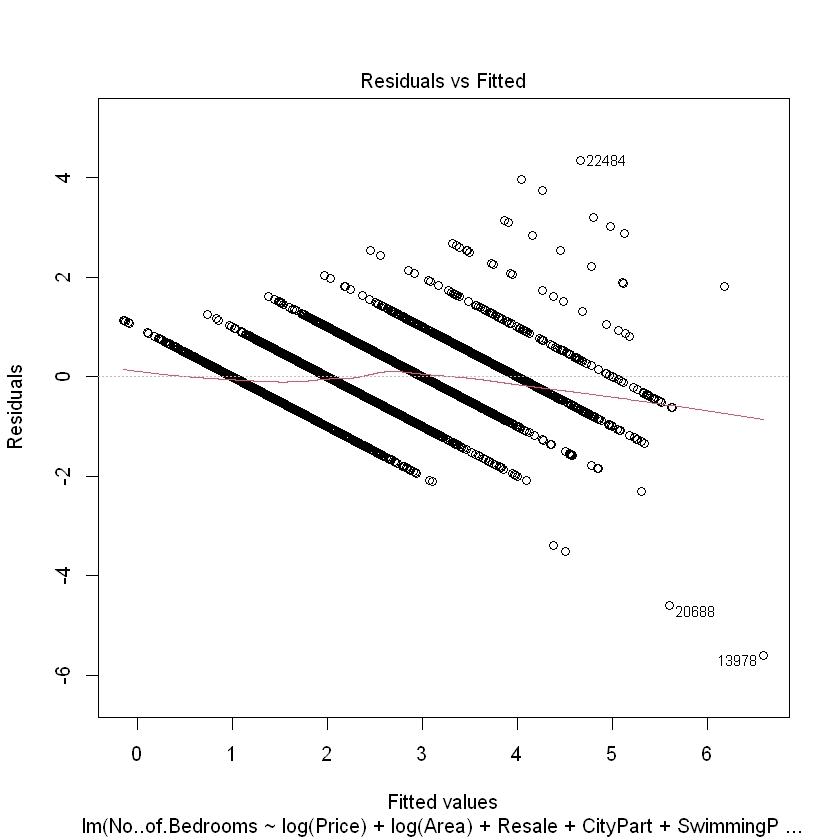

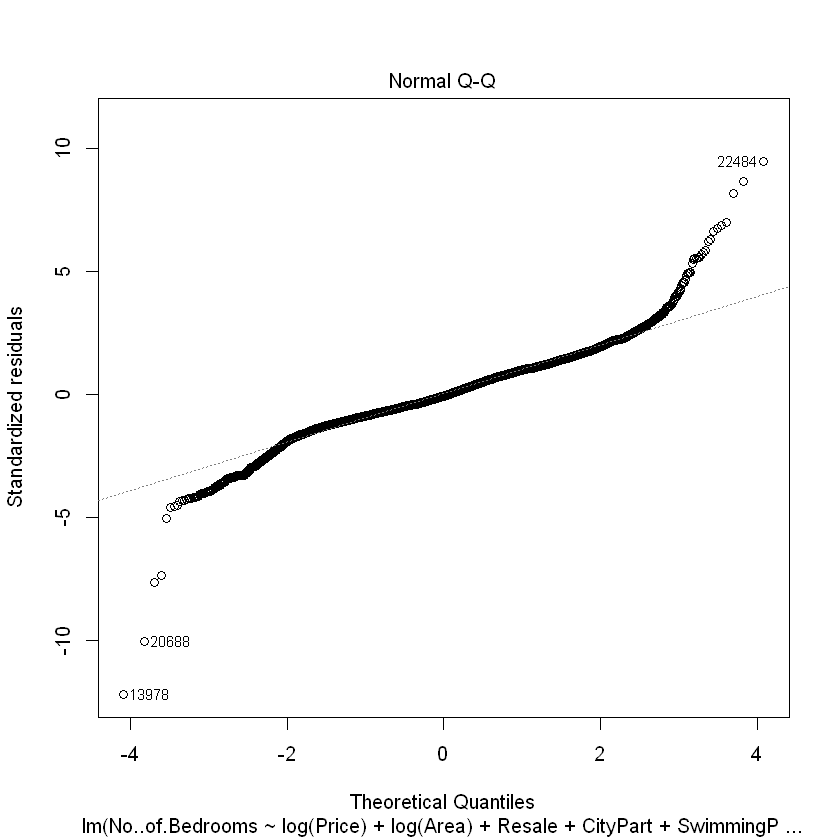

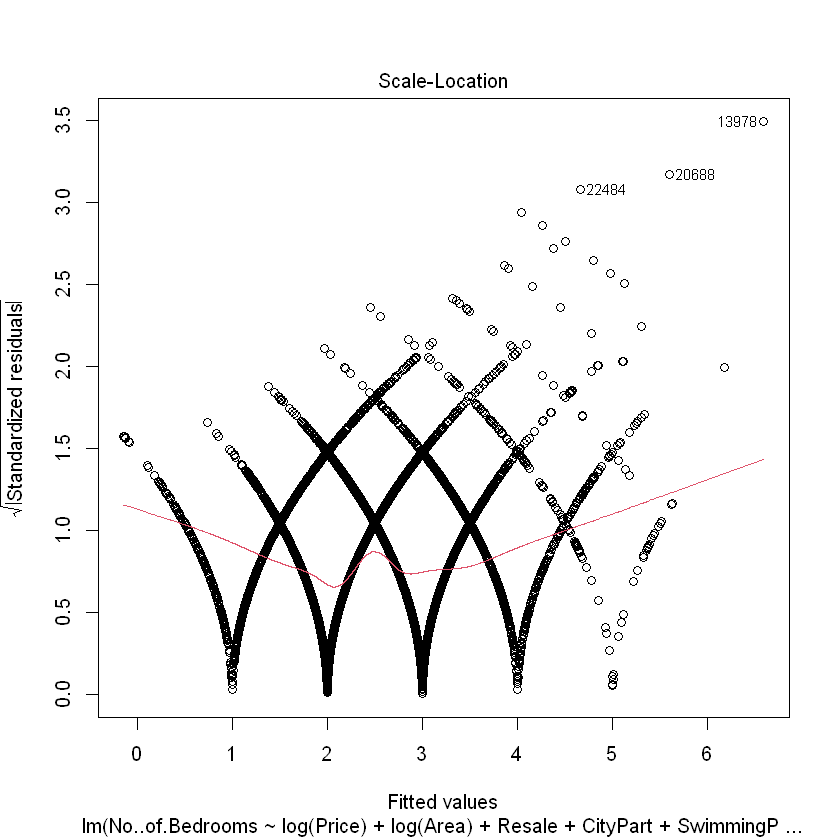

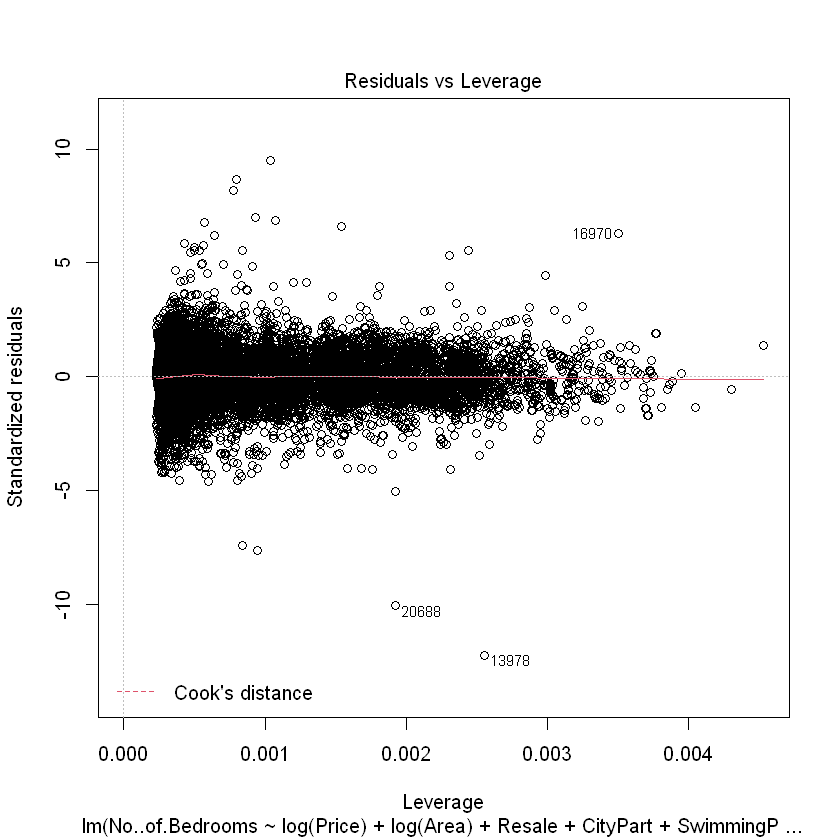

In [22]:
#===LM
model.lm <- lm( data = train, No..of.Bedrooms ~ log(Price) + log(Area) + Resale )
model.lm2 <- lm( data = train, No..of.Bedrooms ~ log(Price) + log(Area) + 
                   Resale + CityPart )
model.lm3 <- lm( data = train, No..of.Bedrooms ~ log(Price) + log(Area) +
                   Resale + CityPart + Children.splayarea )
model.lm4 <- lm( data = train, No..of.Bedrooms ~ log(Price) + log(Area) + Resale + CityPart + 
                        SwimmingPool + RainWaterHarvesting + IndoorGames + Intercom + 
                        PowerBackup + Gasconnection + Children.splayarea + LiftAvailable )
anova(model.lm, model.lm2)
anova(model.lm2, model.lm3)
anova(model.lm3, model.lm4)
# it's the same as gaussian

summary(model.lm4)
confint(model.lm4)

plot(model.lm4)
#plot(model.lm4,5)

In [23]:
# ------------------------> PREDICTION AND VALIDATION <------------------------

predicts.poisson = predict(model.poisson2, newdata = test, type = "response")
rmse( test$No..of.Bedrooms, predicts.poisson )
#factor( round(predicts.poisson) )
#factor( test$No..of.Bedrooms )
cv.poisson = confusionMatrix( factor( round(predicts.poisson) ),
                              factor( test$No..of.Bedrooms ) )
print(cv.poisson)

predicts.poisson = predict(model.poisson3, newdata = test, type = "response")
rmse( test$No..of.Bedrooms, predicts.poisson )
cv.poisson = confusionMatrix( factor( round(predicts.poisson) ),
                              factor( test$No..of.Bedrooms ) )
print(cv.poisson)

predicts.poisson = predict(model.poisson4, newdata = test, type = "response")
rmse( test$No..of.Bedrooms, predicts.poisson )
cv.poisson = confusionMatrix( factor( round(predicts.poisson) ),
                              factor( test$No..of.Bedrooms ) )
print(cv.poisson)

[1] 0.5019486

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5    6    7    8
         1  410   43    0    0    0    0    0    0
         2  691 3965 1149    7    0    0    0    0
         3   14  306 2492  233   10    3    1    0
         4    0   20  104  260   19    3    1    0
         5    0    0   24   47   21    1    0    0
         6    0    0    2   29   10    3    0    1
         7    0    0    2    4   11    0    0    0
         8    0    0    0    0    2    1    0    0

Overall Statistics
                                          
               Accuracy : 0.7231          
                 95% CI : (0.7142, 0.7319)
    No Information Rate : 0.4383          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5511          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 C

[1] 0.5016455

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5    6    7    8
         1  413   46    0    0    0    0    0    0
         2  690 3980 1157    7    0    0    0    0
         3   12  288 2484  234   10    3    1    0
         4    0   20  104  261   20    3    1    0
         5    0    0   24   44   20    1    0    0
         6    0    0    2   30   10    2    0    1
         7    0    0    2    4   11    1    0    0
         8    0    0    0    0    2    1    0    0

Overall Statistics
                                          
               Accuracy : 0.724           
                 95% CI : (0.7151, 0.7328)
    No Information Rate : 0.4383          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5525          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 C

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


[1] 0.5004589

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5    6    7    8
         1  417   45    0    0    0    0    0    0
         2  687 3981 1150    7    0    0    0    0
         3   11  288 2482  234   10    3    1    0
         4    0   20  113  263   20    3    1    0
         5    0    0   24   42   20    1    0    0
         6    0    0    2   30   11    1    0    1
         7    0    0    2    4   10    2    0    0
         8    0    0    0    0    2    1    0    0

Overall Statistics
                                          
               Accuracy : 0.7244          
                 95% CI : (0.7155, 0.7332)
    No Information Rate : 0.4383          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5535          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 C

In [24]:
predicts.gauss <- predict(model.gauss2, newdata = test, type = "response")
predicts.gauss[ predicts.gauss < 0.5 ] = 1
rmse( test$No..of.Bedrooms, predicts.gauss )
cv.gauss = confusionMatrix( factor( round(predicts.gauss) ), 
                         factor( test$No..of.Bedrooms ) )
print(cv.gauss)

predicts.gauss <- predict(model.gauss3, newdata = test, type = "response")
predicts.gauss[ predicts.gauss < 0.5 ] = 1
rmse( test$No..of.Bedrooms, predicts.gauss )
cv.gauss = confusionMatrix( factor( round(predicts.gauss) ), 
                         factor( test$No..of.Bedrooms ) )
print(cv.gauss)
predicts.gauss <- predict(model.gauss4, newdata = test, type = "response")
predicts.gauss[ predicts.gauss < 0.5 ] = 1
rmse( test$No..of.Bedrooms, predicts.gauss )
cv.gauss = confusionMatrix( factor( round(predicts.gauss) ), 
                         factor( test$No..of.Bedrooms ) )
print(cv.gauss)

[1] 0.4572516

Warning message in levels(reference) != levels(data):
"longer object length is not a multiple of shorter object length"
Warning message in confusionMatrix.default(factor(round(predicts.gauss)), factor(test$No..of.Bedrooms)):
"Levels are not in the same order for reference and data. Refactoring data to match."


Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5    6    7    8
         1  711  105    1    0    0    0    0    0
         2  386 3752  768    3    0    0    0    0
         3   18  458 2886  242    9    3    1    0
         4    0   19  108  298   34    4    1    0
         5    0    0   10   37   29    3    0    1
         6    0    0    0    0    1    1    0    0
         7    0    0    0    0    0    0    0    0
         8    0    0    0    0    0    0    0    0

Overall Statistics
                                         
               Accuracy : 0.7763         
                 95% CI : (0.768, 0.7845)
    No Information Rate : 0.4383         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6454         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5  

[1] 0.4560582

Warning message in levels(reference) != levels(data):
"longer object length is not a multiple of shorter object length"
Warning message in confusionMatrix.default(factor(round(predicts.gauss)), factor(test$No..of.Bedrooms)):
"Levels are not in the same order for reference and data. Refactoring data to match."


Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5    6    7    8
         1  707  122    1    0    0    0    0    0
         2  389 3758  759    3    0    0    0    0
         3   19  435 2895  239    9    3    1    0
         4    0   19  108  300   33    4    1    0
         5    0    0   10   38   29    3    0    1
         6    0    0    0    0    2    1    0    0
         7    0    0    0    0    0    0    0    0
         8    0    0    0    0    0    0    0    0

Overall Statistics
                                          
               Accuracy : 0.7776          
                 95% CI : (0.7693, 0.7858)
    No Information Rate : 0.4383          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6477          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 C

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


[1] 0.4540682

Warning message in levels(reference) != levels(data):
"longer object length is not a multiple of shorter object length"
Warning message in confusionMatrix.default(factor(round(predicts.gauss)), factor(test$No..of.Bedrooms)):
"Levels are not in the same order for reference and data. Refactoring data to match."


Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5    6    7    8
         1  709  122    2    0    0    0    0    0
         2  391 3734  753    3    0    0    0    0
         3   15  459 2898  244    9    3    1    0
         4    0   19   97  293   34    4    1    0
         5    0    0   23   40   28    3    0    1
         6    0    0    0    0    2    1    0    0
         7    0    0    0    0    0    0    0    0
         8    0    0    0    0    0    0    0    0

Overall Statistics
                                          
               Accuracy : 0.7749          
                 95% CI : (0.7665, 0.7831)
    No Information Rate : 0.4383          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6435          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 C

In [25]:
predicts.lm <- predict(model.lm2, newdata = test, type = "response")
predicts.lm[ predicts.lm < 0.5 ] = 1
rmse( test$No..of.Bedrooms, predicts.lm )
cv.lm = confusionMatrix( factor( round(predicts.lm) ), 
                         factor( test$No..of.Bedrooms ) )
print(cv.lm)

predicts.lm <- predict(model.lm3, newdata = test, type = "response")
predicts.lm[ predicts.lm < 0.5 ] = 1
rmse( test$No..of.Bedrooms, predicts.lm )
cv.lm = confusionMatrix( factor( round(predicts.lm) ), 
                         factor( test$No..of.Bedrooms ) )
print(cv.lm)

predicts.lm <- predict(model.lm4, newdata = test, type = "response")
predicts.lm[ predicts.lm < 0.5 ] = 1
rmse( test$No..of.Bedrooms, predicts.lm )
cv.lm = confusionMatrix( factor( round(predicts.lm) ), 
                         factor( test$No..of.Bedrooms ) )
print(cv.lm)
# best achieved accuracy is around 0.7776, with most errors being just +-1 room 
#   (its an ok model, although the interpretation is problematic with the negative intercept)

[1] 0.4572516

Warning message in levels(reference) != levels(data):
"longer object length is not a multiple of shorter object length"
Warning message in confusionMatrix.default(factor(round(predicts.lm)), factor(test$No..of.Bedrooms)):
"Levels are not in the same order for reference and data. Refactoring data to match."


Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5    6    7    8
         1  711  105    1    0    0    0    0    0
         2  386 3752  768    3    0    0    0    0
         3   18  458 2886  242    9    3    1    0
         4    0   19  108  298   34    4    1    0
         5    0    0   10   37   29    3    0    1
         6    0    0    0    0    1    1    0    0
         7    0    0    0    0    0    0    0    0
         8    0    0    0    0    0    0    0    0

Overall Statistics
                                         
               Accuracy : 0.7763         
                 95% CI : (0.768, 0.7845)
    No Information Rate : 0.4383         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6454         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5  

[1] 0.4560582

Warning message in levels(reference) != levels(data):
"longer object length is not a multiple of shorter object length"
Warning message in confusionMatrix.default(factor(round(predicts.lm)), factor(test$No..of.Bedrooms)):
"Levels are not in the same order for reference and data. Refactoring data to match."


Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5    6    7    8
         1  707  122    1    0    0    0    0    0
         2  389 3758  759    3    0    0    0    0
         3   19  435 2895  239    9    3    1    0
         4    0   19  108  300   33    4    1    0
         5    0    0   10   38   29    3    0    1
         6    0    0    0    0    2    1    0    0
         7    0    0    0    0    0    0    0    0
         8    0    0    0    0    0    0    0    0

Overall Statistics
                                          
               Accuracy : 0.7776          
                 95% CI : (0.7693, 0.7858)
    No Information Rate : 0.4383          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6477          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 C

Warning message in predict.lm(model.lm4, newdata = test, type = "response"):
"prediction from a rank-deficient fit may be misleading"


[1] 0.4540682

Warning message in levels(reference) != levels(data):
"longer object length is not a multiple of shorter object length"
Warning message in confusionMatrix.default(factor(round(predicts.lm)), factor(test$No..of.Bedrooms)):
"Levels are not in the same order for reference and data. Refactoring data to match."


Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5    6    7    8
         1  709  122    2    0    0    0    0    0
         2  391 3734  753    3    0    0    0    0
         3   15  459 2898  244    9    3    1    0
         4    0   19   97  293   34    4    1    0
         5    0    0   23   40   28    3    0    1
         6    0    0    0    0    2    1    0    0
         7    0    0    0    0    0    0    0    0
         8    0    0    0    0    0    0    0    0

Overall Statistics
                                          
               Accuracy : 0.7749          
                 95% CI : (0.7665, 0.7831)
    No Information Rate : 0.4383          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6435          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 C

Visualizing the prediction errors in the test data: 

In [26]:
#Create a custom color scale
library(RColorBrewer)
myColors <- brewer.pal(9,"Set1")
names(myColors) <- levels(factor(1:9))
colScale <- scale_colour_manual(name = "grp",values = myColors)

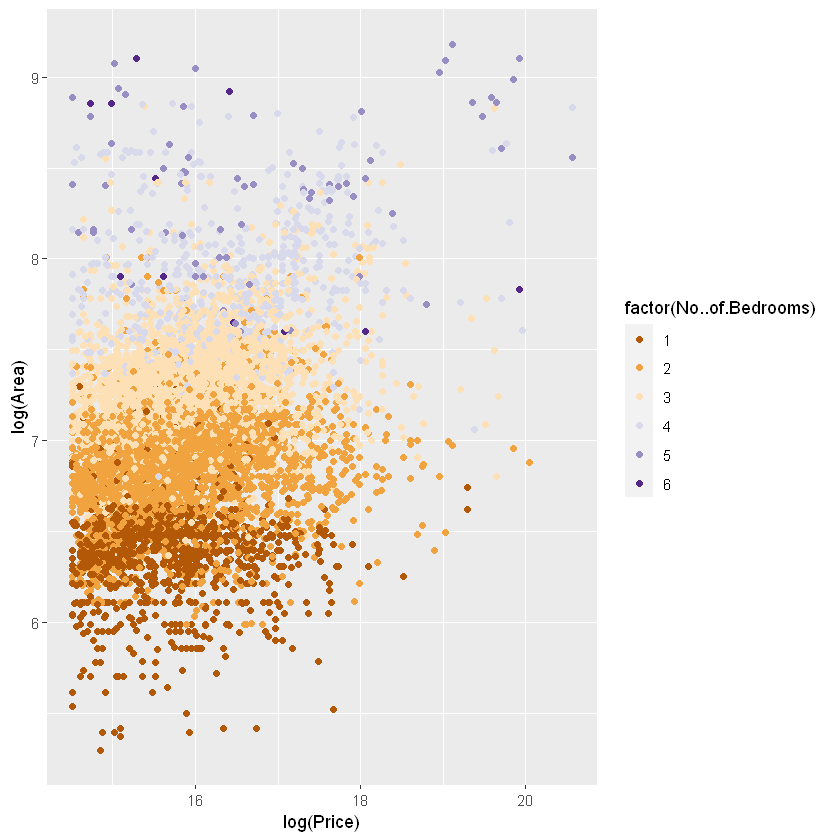

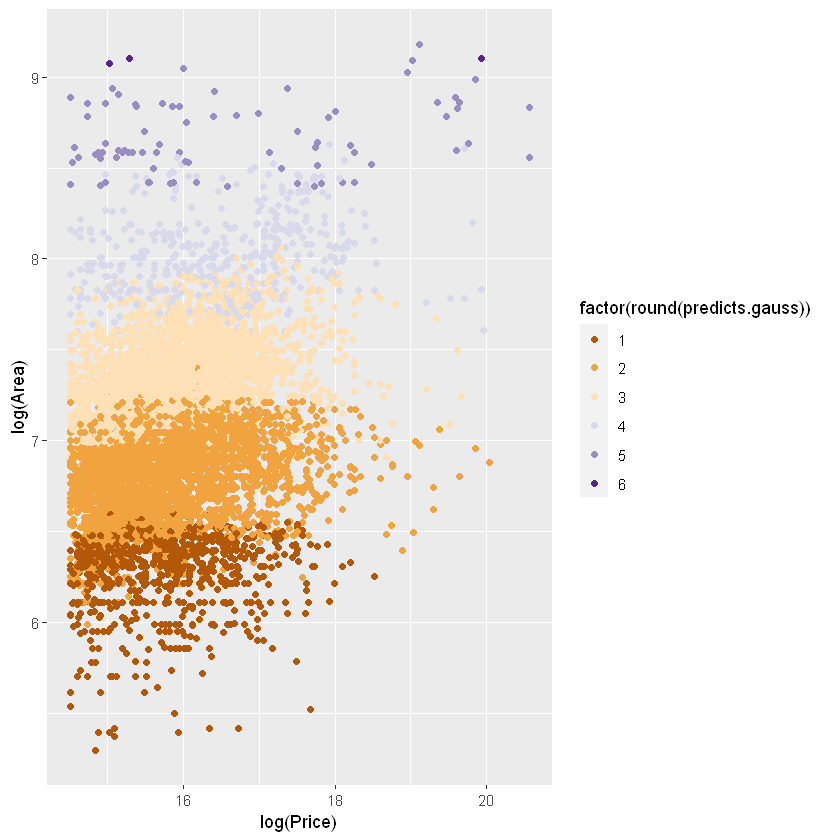

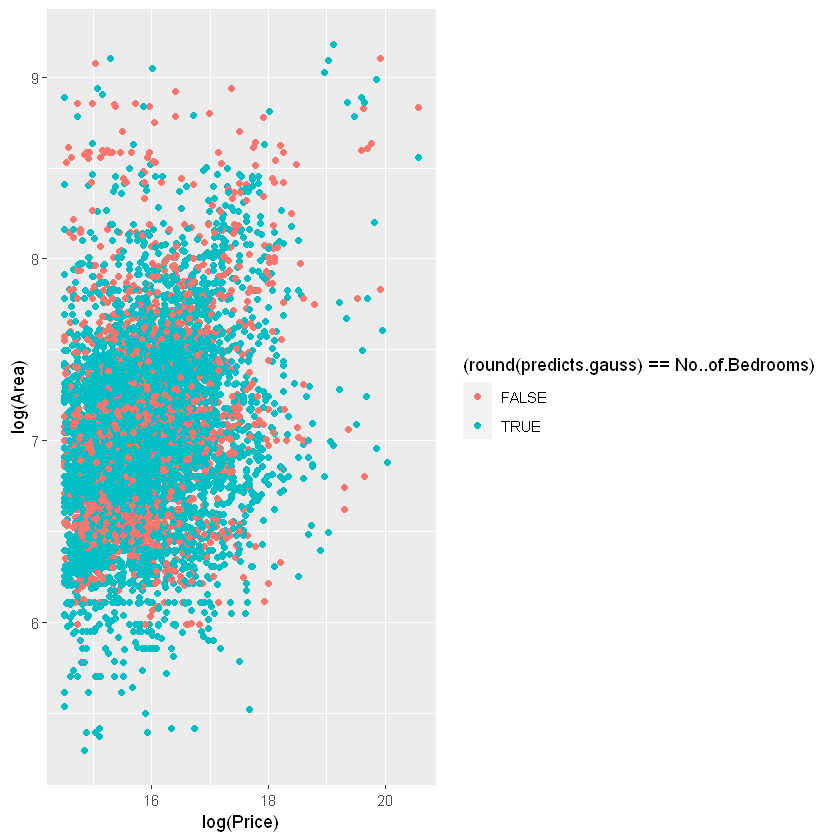

In [27]:
# test %>% filter(No..of.Bedrooms < 5)
ggplot(test %>% filter(No..of.Bedrooms < 7) , aes(x=log(Price), y=log(Area) ) ) + 
    geom_point( aes(color = factor( No..of.Bedrooms ) ) ) + 
    scale_color_brewer(palette = "PuOr")

ggplot(test, aes(x=log(Price), y=log(Area) ) ) + 
    geom_point( aes(color = factor( round(predicts.gauss) ) ) ) + 
    scale_color_brewer(palette = "PuOr")

ggplot(test, aes(x=log(Price), y=log(Area) ) ) + 
    geom_point( aes(color = ( round(predicts.gauss) == No..of.Bedrooms ) ) )

## Conclusions

The best performing model here is just a classic linear model with log-transformed Price and Area, though the interpretation of the intercept is a bit problematic - a house with zero price and area would have -7 rooms (this was actually solved "mechanically" by setting all predictions lower than 0.5 to be 1). But it predicts fairly well - actually just using the formula 

<No..of.Bedrooms ~ log(Price) + log(Area) + Resale + CityPart> 

gives us very good accuracy, using the binary categories just gives us a slight improvement, and they come with the problems mentioned above.

What do do differently? Well, log(Price) has a statistically significant but very small effect - usually it's a good sign to have not many explanatory variables, which all have a "big" effect. That was the case for the best project in the seminar. They achieved that by dividing price into categories, and then having it interact with the CityPart variable. If I find the time, I will try that too :-)

Also, setting an offset of 1 in the Poisson model would be a good idea, because the rooms start from 1 - there can be no house with 0 rooms. And for that matter, it would probably be better to use quasi-poisson, since the variance is not equal to mean.